<a href="https://colab.research.google.com/github/Lkrasnop/Master-degree-Data_science_final_project/blob/data-preparation/Final_Project_EDA_class_data_preparation_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final project - Lior Krasnopolski and Karin Shauli - class of data preparation

##google drive activation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Packages

In [2]:
import pandas as pd
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
import numpy as np
from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures


#ann model packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout , MaxPool2D
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.layers import Dense,Dropout, Flatten , Conv2D, MaxPooling2D , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# data preparation class

In [3]:
class data_preparation:
  def __init__(self
               #parameters of our source
               ,our_path_gene_source
               ,gene_primry_desc
               ,elias_gene_desc
               ,symbol_splitting
               #article parameters
               ,article_path_gen_source
               ,article_gene_primry_desc
               ,article_gene_elias_desc
               ,article_symbol_splitting
               #normalized parameters
               ,normalized_data_path
               #patient info
               ,patient_info_path
               #saving path for comparision function between our gene elias and article's elias data set
               ,path_to_dataframe_our_vs_article
               #saving final normalized data frame
               ,path_for_df_normalized_final
               #Thresholds
               ,Threshold_r2
               ,max_degree):

    ###initialize parameters ########################################################
    #parameters for our gene data set
    self.our_path_gene_source = our_path_gene_source
    self.gene_primry_desc = gene_primry_desc
    self.elias_gene_desc = elias_gene_desc
    self.symbol_splitting = symbol_splitting
    #parameters for article gene data set
    self.article_gene_primry_desc = article_gene_primry_desc
    self.symbol_splitting_article = article_symbol_splitting
    self.article_path_gen_source = article_path_gen_source
    self.article_gene_elias_desc = article_gene_elias_desc
    #parameters for our normalized data set
    self.normalized_data_path = normalized_data_path
    #parameters for patient info
    self.patient_info_path = patient_info_path
    #parameters for saving path for comparision function between our gene elias and article's elias data set
    self.path_to_dataframe_our_vs_article = path_to_dataframe_our_vs_article
    #saving final normalized data frame
    self.path_for_df_normalized_final = path_for_df_normalized_final
    #Thresholds
    self.Threshold_r2 = Threshold_r2
    #max approximation degree
    self.max_degree = max_degree


  ###perapre our gene data set updated ##############################################
  def our_gene_desc_updated(self):
    df_our_gene_data_orginal = pd.read_csv('{}'.format(self.our_path_gene_source))
    df_our_gene_data_orginal = df_our_gene_data_orginal[['{}'.format(self.gene_primry_desc),
                                                         '{}'.format(self.elias_gene_desc)]].drop_duplicates().reset_index(drop = True)
    #split the name into two columns in order to get name column with first assignment.
    df_our_gene_data = df_our_gene_data_orginal.copy()
    df_our_gene_data['{}'.format(self.elias_gene_desc)] = df_our_gene_data['{}'.format(self.elias_gene_desc)].str.split('{}'.format(self.symbol_splitting)).str[0]

    #get our elias data
    df_our_gene_elias = df_our_gene_data_orginal['{}'.format(self.elias_gene_desc)].str.split('{}'.format(self.symbol_splitting), expand=True)

    #rename the elias columns description
    for elem in range(0,len(df_our_gene_elias.columns)):
        df_our_gene_elias.rename(columns={elem:"alias-our-dataframe {}".format(elem+1)},inplace =True)
    df_our_gene_elias = df_our_gene_elias.drop_duplicates().reset_index(drop = True)

    #clean the original data with elias primary name
    cleaned_our_data_gene_set = df_our_gene_data.loc[df_our_gene_data['{}'.format(self.elias_gene_desc)].isin(df_our_gene_elias['alias-our-dataframe 1'])].dropna()
    return df_our_gene_data ,cleaned_our_data_gene_set,  df_our_gene_elias


  ###perapre article gene data set##############################################
  def article_gene_source(self):
    # gert of list_sheet_names
    df = pd.ExcelFile('{}'.format(self.article_path_gen_source))
    list_sheet_names = df.sheet_names
    del df
    # get dataframe for gene dataset from aritcle
    data_frame_gene = []
    for name in list_sheet_names:
      temp = pd.read_excel('{}'.format(self.article_path_gen_source) , sheet_name='{}'.format(name))
      temp = temp[['{}'.format(self.article_gene_primry_desc),'{}'.format(self.article_gene_elias_desc)]]
      temp['group_name'] = name
      data_frame_gene.append(temp)

    data_frame_gene = pd.concat(data_frame_gene)
    #split the alias
    split_alias = data_frame_gene['{}'.format(self.article_gene_elias_desc)].str.split('{}'.format(self.symbol_splitting_article), expand=True)
    #change names of added columns
    for elem in range(0,len(split_alias.columns)):
      split_alias.rename(columns={elem:"alias {}".format(elem+1)},inplace =True)
    #merge alias splited dataframe into gene frame
    data_frame_gene = pd.concat([data_frame_gene, split_alias], axis=1)
    #drop alias inital column
    data_frame_gene = data_frame_gene.drop(['{}'.format(self.article_gene_elias_desc)], axis = 1)
    return data_frame_gene


  ###get normalized data for each patient##############################################
  #taking almost 3 hours to complete the execution of this function
  def genes_from_article_source_isin_genes_from_our_source(self):
    #article
    data_frame_article_gene_source = self.article_gene_source()
    data_frame_our_gene_source = self.our_gene_desc_updated()
    data_frame_our_gene_source = data_frame_our_gene_source[2]
    #create initial dataframe for gene names from artile and our sources
    data = {'article': [], 'our_source': []}
    df_article_vs_our_source = pd.DataFrame(data)
    elias = data_frame_our_gene_source.fillna("None")
    acadaemic = data_frame_article_gene_source.fillna("None")

    for elem_idx in range(len(elias)):
        for elem2_idx in range(len(acadaemic)):
          our = [value for value in elias.iloc[elem_idx, :] if "None" not in str(value)]
          article = [value for value in acadaemic.iloc[elem2_idx, :] if "None" not in str(value)]
          if any(word1 in our for word1 in article):
              # add to two different columns at the same dataframe
              df_article_vs_our_source = df_article_vs_our_source.append({'our_source': elias.iloc[elem_idx, 0], 'article': acadaemic.iloc[elem2_idx, 0]}, ignore_index=True)
        #rename 'our_source' column
        df_article_vs_our_source.rename(columns={'our_source':"gene"},inplace =True)

        #remove duplicates
        df_article_vs_our_source = df_new_article.drop_duplicates().reset_index(drop =True)

        #saving the data frame
        df_article_vs_our_source.to_csv('{}'.format(self.path_to_dataframe_our_vs_article))
        return df_article_vs_our_source

  ### percentage of gene integrity compare before and after cleaning#####################
  def percentage_of_gene_integrity(self):
    article_data_before = self.article_gene_source()
    article_data_after = pd.read_csv('{}'.format(self.path_to_dataframe_our_vs_article))
    article_data_after.rename(columns={'our_source':"gene"},inplace =True)
    #print the results before and after
    print('before cleaning irrelevant genes: {}'.format(article_data_before['{}'.format(self.article_gene_primry_desc)].nunique()))
    print('after cleaning irrelevant genes: {}'.format(article_data_after['article'].nunique()))
    ratio = np.round((1-((article_data_before['{}'.format(self.article_gene_primry_desc)].nunique()- article_data_after['article'].nunique())/article_data_before['{}'.format(self.article_gene_primry_desc)].nunique()))*100,2)
    return print('percentage of integrity: {} %'.format(ratio))


  ###get normalized data for each patient################################################
  def get_normalized_data(self):
    df_normalized_celltype_reconstruct  = pd.read_csv('{}'.format(self.normalized_data_path))
    df_normalized_celltype_reconstruct = df_normalized_celltype_reconstruct.drop(columns = ['Unnamed: 0'] , axis=1)
    return df_normalized_celltype_reconstruct


  ###get pateint info data set##########################################################
  def get_patient_info(self):
    df_info = pd.read_csv('{}'.format(self.patient_info_path))
    #filter by required parameters
    df_info = df_info[(df_info['gender']== 'Male')] #maybe this condition should be removed
    df_info = df_info[(df_info['age']>=20) & (df_info['age']<=80)] #maybe this condition should be removed
    df_info = df_info.reset_index(drop = True)
    df_info.rename(columns={'GSM':"source_name"},inplace =True)
    return df_info

  #get gene and gc after cleaning the irrelevant cases###################################
  def get_final_our_gene_data_set(self):
    our_gene_after_comparison_with_article = pd.read_csv('{}'.format(self.path_to_dataframe_our_vs_article))
    our_gene_after_comparison_with_article.rename(columns={'our_source':"gene"},inplace =True)
    gene_and_cg_after_inital_cleaning = self.our_gene_desc_updated()[1]
    #merging dataframes
    final_our_gene_data_set = pd.merge(gene_and_cg_after_inital_cleaning,
                                       our_gene_after_comparison_with_article,
                                       left_on = ['{}'.format(self.elias_gene_desc)],
                                       right_on = ['gene'],
                                       how = 'inner')
    final_our_gene_data_set = final_our_gene_data_set.drop(['Unnamed: 0','gene'] , axis = 1)
    final_our_gene_data_set.rename(columns={'{}'.format(self.elias_gene_desc):"our_gene"},inplace =True)
    return final_our_gene_data_set

  ###get normalized data for each patient after cleaning cgs and source name ###########
  def get_normalized_data_after_cleaning(self):
    data_frame_gene = self.get_final_our_gene_data_set()
    df_normalized_celltype_reconstruct = self.get_normalized_data()
    df_info = self.get_patient_info()

    #filtering only the relevant cgs
    df_normalized_final = df_normalized_celltype_reconstruct.loc[df_normalized_celltype_reconstruct['source_name'].isin(df_info['source_name'])]
    df_normalized_final = df_normalized_final.loc[df_normalized_final['cg'].isin(data_frame_gene['Name'])]
    df_normalized_final = df_normalized_final.dropna()

    #merge the final normalized data frame
    df_normalized_final = pd.merge(df_normalized_final ,df_info , left_on =['source_name'] , right_on=['source_name'],how='left' )
    df_normalized_final = pd.merge(df_normalized_final ,data_frame_gene , left_on =['cg'] , right_on=['Name'],how='left' )

    #drop irrelevant columns
    df_normalized_final = df_normalized_final.drop(['disease state','gender','tissue','Name'] , axis = 1)

    #chagne column name from normalized to value
    df_normalized_final.rename(columns={'normalized':"value"},inplace =True)

    #data frame article genes and their group name
    # article_gene_with_group_name = self.article_gene_source()[['{}'.format(self.article_gene_primry_desc),'group_name']]

    #add group name column###################
    # #merge final dataframe
    # df_normalized_final = pd.merge(df_normalized_final ,
    #                                 article_gene_with_group_name ,
    #                                 left_on = ['article'] ,
    #                                 right_on = ['{}'.format(self.article_gene_primry_desc)] ,
    #                                 how = 'left').drop(['{}'.format(self.article_gene_primry_desc)], axis= 1)

    #saving dataframe
    df_normalized_final.to_csv('{}'.format(self.path_for_df_normalized_final))

    return df_normalized_final

  ###get linear approximation for our data ###########
  def linear_approximation(self):
      #values dataframe
      df_normalized_final = pd.read_csv('{}'.format(self.path_for_df_normalized_final))
      df_normalized_final = df_normalized_final.drop(['Unnamed: 0'], axis= 1)
      df_normalized_final = df_normalized_final.groupby(['article','age','cg']).mean('value').reset_index()

      #grouped
      grouped = df_normalized_final.groupby(['cg'])

      #initalized dataframe
      coefficients_df = pd.DataFrame(columns=['cg', 'a', 'b', 'r^2'])

      for cg, group in grouped:
          X = group[['age']]
          y = group['value']

          # Initialize the linear regression model for each group
          model = LinearRegression()

          # Fit the linear regression model
          model.fit(X, y)
          y_pred = model.predict(X)
          r2 = r2_score(y, y_pred)

          # Get the coefficients
          a = model.coef_[0]
          b = model.intercept_

          # Append the coefficients and R-squared values to the coefficients DataFrame
          new_row = pd.DataFrame({'cg': [cg], 'a': [a], 'b': [b], 'r^2': [r2]})
          coefficients_df = pd.concat([coefficients_df, new_row], ignore_index=True)

      return coefficients_df

  ###get linear approximation of varience of our data ###########
  def linear_approximation_var(self):
      #values dataframe
      df_normalized_final = pd.read_csv('{}'.format(self.path_for_df_normalized_final))
      df_normalized_final = df_normalized_final.drop(['Unnamed: 0'], axis= 1)
      df_normalized_final = df_normalized_final.groupby(['article','age','cg']).var().reset_index()
      display(df_normalized_final)
      df_normalized_final = df_normalized_final.dropna()

      #grouped
      grouped = df_normalized_final.groupby(['cg'])

      #initalized dataframe
      coefficients_df = pd.DataFrame(columns=['cg', 'a', 'b', 'r^2'])

      for cg, group in grouped:
          X = group[['age']]
          y = group['value']

          # Initialize the linear regression model for each group
          model = LinearRegression()

          # Fit the linear regression model
          model.fit(X, y)
          y_pred = model.predict(X)
          r2 = r2_score(y, y_pred)

          # Get the coefficients
          a = model.coef_[0]
          b = model.intercept_

          # Append the coefficients and R-squared values to the coefficients DataFrame
          new_row = pd.DataFrame({'cg': [cg], 'a': [a], 'b': [b], 'r^2': [r2]})
          coefficients_df = pd.concat([coefficients_df, new_row], ignore_index=True)
          # coefficients_df = coefficients_df.append({'cg': cg, 'a': a, 'b': b, 'r^2': r2}, ignore_index=True)

      return coefficients_df

  ###get non-linear/linear approximation of mean of our data ###########
  def linear_approximation_poly(self):
    df_normalized_final = pd.read_csv('{}'.format(self.path_for_df_normalized_final))
    df_normalized_final = df_normalized_final.drop(['Unnamed: 0'], axis= 1)
    df_normalized_final = df_normalized_final.groupby(['article','age','cg']).mean('value').reset_index().sort_values(by=['cg', 'age'])
    df_normalized_final = df_normalized_final.dropna()

    #grouped by cg and age
    grouped = df_normalized_final.groupby(['cg','age']).mean().reset_index()
    #get cgsunique list
    cg_list = list(grouped['cg'].unique())

    coefficients_df = pd.DataFrame(columns=['cg','degree' 'a', 'b', 'r^2'])
    for cg in cg_list:
      x = np.array(grouped[grouped['cg'] == cg]['age']).reshape(-1, 1)
      y = np.array(grouped[grouped['cg'] == cg]['value']).reshape(-1, 1)
      for elem in range(1,self.max_degree + 1):
          poly = PolynomialFeatures(degree=elem)
          X_poly = poly.fit_transform(x)
          model = LinearRegression()
          model.fit(X_poly, y)
          a = np.round(model.coef_[0],2)
          b = np.round(model.intercept_,2)
          y_pred = model.predict(X_poly)
          r2 = r2_score(y, y_pred)
          if a.max() > 0:
            if r2 >= self.Threshold_r2:
                new_row = pd.DataFrame({'cg': [cg],'degree':[elem+1] ,'a': [a], 'b': [b], 'r^2': [r2]})
                coefficients_df = pd.concat([coefficients_df, new_row], ignore_index=True)

    coefficients_df = coefficients_df.sort_values(by=['r^2'] , ascending=False).reset_index()
    return coefficients_df

   ###get non-linear/linear approximation of varience of our data ###########
  def linear_approximation_poly_var(self):
    df_normalized_final = pd.read_csv('{}'.format(self.path_for_df_normalized_final))
    df_normalized_final = df_normalized_final.drop(['Unnamed: 0'], axis= 1)
    df_normalized_final = df_normalized_final.groupby(['age','cg'])['value'].var().reset_index().sort_values(by=['cg', 'age'])
    df_normalized_final = df_normalized_final.dropna()

    #grouped by cg and age
    grouped = df_normalized_final.groupby(['cg','age']).var().reset_index()
    #get cgsunique list
    cg_list = list(grouped['cg'].unique())

    coefficients_df = pd.DataFrame(columns=['cg','degree' 'a', 'b', 'r^2'])
    for cg in cg_list:
      x = np.array(df_normalized_final[df_normalized_final['cg'] == cg]['age']).reshape(-1, 1)
      y = np.array(df_normalized_final[df_normalized_final['cg'] == cg]['value']).reshape(-1, 1)
      for elem in range(1,self.max_degree + 1):
          poly = PolynomialFeatures(degree=elem)
          X_poly = poly.fit_transform(x)
          model = LinearRegression()
          model.fit(X_poly, y)
          a = np.round(model.coef_[0],2)
          b = np.round(model.intercept_,2)
          y_pred = model.predict(X_poly)
          r2 = r2_score(y, y_pred)
          if a.max() > 0:
            if r2 >= self.Threshold_r2:
                new_row = pd.DataFrame({'cg': [cg],'degree':[elem+1] ,'a': [a], 'b': [b], 'r^2': [r2]})
                coefficients_df = pd.concat([coefficients_df, new_row], ignore_index=True)

    coefficients_df = coefficients_df.sort_values(by=['r^2'] , ascending=False).reset_index()
    return coefficients_df


  ###initial ANN model ######################
  def ann(self):
    #import the dataframe
    df = self.get_normalized_data_after_cleaning()[['source_name','cg','value','age','article']]

    #treatment categorical columns
    cat_columns=['source_name','cg','article']
    df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0] + 2)


    #initiate x and y
    Y = (df['value']).values
    x = df.drop(['value'], axis = 1)
    x = (x).values

    #split to train and test
    X_train, X_test, Y_train, Y_test = train_test_split(x,Y, test_size = 0.10, random_state = 42)

    #model structure
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout((0.5)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout((0.5)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='softmax'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    #exceution of ann model
    epochs = 20
    batch_size = 64
    history = model.fit(X_train, Y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.1
                        ,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

    return history

# initiate parameters

In [4]:
#our gene source - parameters
our_gene_path = '/content/drive/MyDrive/Final Project Data Science Master/קבצים ישנים/all_450K.csv'
gene_primry_desc = 'Name'
elias_gene_desc = 'UCSC_RefGene_Name'
symbol_splitting = ';'

#article - parameters
article_path_gen_source = '/content/drive/MyDrive/Final Project Data Science Master/ 41419_2021_4121_MOESM1_ESM_cleaned.xlsx'
article_gene_primry_desc = 'Official Gene symbol'
article_gene_elias_desc = 'Alias (optional)'
symbol_splitting_article = ','

#normalized data parameters
normalized_data_path = '/content/drive/MyDrive/Final Project Data Science Master/df_GSE87571_normalized_celltype_reconstruct.csv'

#patient info data set
patient_info_path = '/content/drive/MyDrive/Final Project Data Science Master/GSE87571_info.csv'


#######saving paths###################
#saving path for comparision function between our gene elias and article's elias data set
path_to_dataframe_our_vs_article = '/content/drive/MyDrive/Final Project Data Science Master/data preparation/df_article_vs_our_source.csv'

#saving path for final normalized dataframe
path_for_df_normalized_final = '/content/drive/MyDrive/Final Project Data Science Master/data preparation/df_normalized_final.csv'

#threshold
Threshold_r2 = 0.5

#max approximation degree
max_degree = 20

data_preparation = data_preparation(our_gene_path,
                                    gene_primry_desc,
                                    elias_gene_desc,
                                    symbol_splitting,
                                    article_path_gen_source,
                                    article_gene_primry_desc,
                                    article_gene_elias_desc,
                                    symbol_splitting_article,
                                    normalized_data_path,
                                    patient_info_path,
                                    path_to_dataframe_our_vs_article,
                                    path_for_df_normalized_final,
                                    Threshold_r2,
                                    max_degree)

#Applying functions

##percentage of integrity

In [ ]:
percentage = data_preparation.percentage_of_gene_integrity()
percentage

<ipython-input-4-f78d2f60bf48>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['group_name'] = name


before cleaning irrelevant genes: 604
after cleaning irrelevant genes: 571
percentage of integrity: 94.54 %


##our dataframe

In [ ]:
df = pd.read_csv(path_for_df_normalized_final).drop(['Unnamed: 0'], axis = 1)
#adding prob sequence full
df_gene_prob_sequence = pd.read_csv(our_gene_path)

df_gene_prob_sequence = df_gene_prob_sequence[['Name','AlleleA_ProbeSeq']]

#merging
df_final = pd.merge(df , df_gene_prob_sequence
                 , how='left'
                 , left_on='cg'
                 , right_on='Name')

df_final = df_final.drop(['Name'], axis = 1)

display(df_final)

average_units = df_final['AlleleA_ProbeSeq'].str.len().max()

print(f"The average number of characters in the column is: {average_units}")

<ipython-input-45-182e3248ca17>:3: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gene_prob_sequence = pd.read_csv(our_gene_path)


,source_name,cg,value,age,our_gene,article,AlleleA_ProbeSeq
0,GSM2333902,cg00002028,0.022672,55.0,PINK1,PINK1,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAAC...
1,GSM2333903,cg00002028,0.020650,23.0,PINK1,PINK1,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAAC...
2,GSM2333901,cg00002028,0.025571,72.0,PINK1,PINK1,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAAC...
3,GSM2333905,cg00002028,0.035011,74.0,PINK1,PINK1,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAAC...
4,GSM2333908,cg00002028,0.031354,38.0,PINK1,PINK1,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAAC...
...,...,...,...,...,...,...,...
3277736,GSM2334627,cg27664530,0.070926,53.0,PIK3AP1,PIK3AP1,CCTAAACTCCRTAAACCCACAAAAAACRCTCAAACAATCCTAAATA...
3277737,GSM2334630,cg27664530,0.124881,70.0,PIK3AP1,PIK3AP1,CCTAAACTCCRTAAACCCACAAAAAACRCTCAAACAATCCTAAATA...
3277738,GSM2334631,cg27664530,0.111110,72.0,PIK3AP1,PIK3AP1,CCTAAACTCCRTAAACCCACAAAAAACRCTCAAACAATCCTAAATA...
3277739,GSM2334632,cg27664530,0.118449,54.0,PIK3AP1,PIK3AP1,CCTAAACTCCRTAAACCCACAAAAAACRCTCAAACAATCCTAAATA...


The average number of characters in the column is: 50


In [ ]:
df_final['cg'].nunique()

11716

##linear approximations

###general linear approximation

In [ ]:
func_lin = data_preparation.linear_approximation()
func_lin['r']= np.sqrt(func_lin['r^2'])
func_lin.sort_values(by=['r^2'], ascending = False)
func_lin[func_lin['r^2']<=0.8]

<ipython-input-3-43e58a52b3ec>:216: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for cg, group in grouped:


,cg,a,b,r^2,r
0,cg00002028,0.000092,0.022566,0.289071,0.537653
1,cg00006122,0.000028,0.028194,0.021457,0.146483
2,cg00008621,0.000014,0.981393,0.008070,0.089833
3,cg00009167,-0.000028,0.042138,0.009919,0.099597
4,cg00010445,0.001089,0.212985,0.524309,0.724092
...,...,...,...,...,...
11711,cg27651035,0.000038,0.014581,0.124202,0.352423
11712,cg27654787,-0.000035,0.060195,0.007532,0.086787
11713,cg27656398,-0.000063,0.070874,0.012153,0.110239
11714,cg27660720,0.000136,0.923974,0.039344,0.198353


In [ ]:
func_lin = data_preparation.linear_approximation()
func_lin = func_lin.sort_values(by=['r^2'], ascending = False)
func_lin['r^2'].max()

<ipython-input-3-43e58a52b3ec>:216: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for cg, group in grouped:


0.7985391366998178

###cgs with r^2 less than 0.5

In [ ]:
func_lin[func_lin['r^2']<0.5].reset_index(drop = True)

,cg,a,b,r^2
0,cg24125828,0.004089,0.442089,0.798539
1,cg08376141,0.001989,0.174441,0.713650
2,cg11945824,0.002166,0.019307,0.702046
3,cg13782301,0.002306,0.224790,0.698260
4,cg25955180,0.001745,0.072998,0.697868
...,...,...,...,...
81,cg13653144,0.000937,0.086132,0.505579
82,cg18501647,0.001540,0.636833,0.505495
83,cg19286604,0.000719,0.067814,0.502150
84,cg05142211,0.001066,0.027250,0.501779


###linear approximation - varience

In [ ]:
func = data_preparation.linear_approximation_var()
func['r']= np.sqrt(func['r^2'])
ֿfunc

<ipython-input-11-43e58a52b3ec>:243: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_normalized_final = df_normalized_final.groupby(['article','age','cg']).var().reset_index()


,article,age,cg,value
0,ABCA2,20.0,cg00785831,0.000023
1,ABCA2,20.0,cg02663193,0.000121
2,ABCA2,20.0,cg02679745,0.000376
3,ABCA2,20.0,cg02820283,0.000524
4,ABCA2,20.0,cg02971262,0.000289
...,...,...,...,...
721808,ZNRF2,80.0,cg10289912,0.000052
721809,ZNRF2,80.0,cg16238026,0.002924
721810,ZNRF2,80.0,cg17460047,0.000005
721811,ZNRF2,80.0,cg21557180,0.000407


<ipython-input-11-43e58a52b3ec>:253: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for cg, group in grouped:


,cg,a,b,r^2,r
0,cg00002028,7.460189e-07,0.000001,0.108514,0.329415
1,cg00006122,1.232322e-07,0.000039,0.002725,0.052201
2,cg00008621,-1.467787e-07,0.000035,0.009766,0.098822
3,cg00009167,6.877671e-07,0.000022,0.042723,0.206696
4,cg00010445,2.605066e-05,-0.000088,0.152689,0.390754
...,...,...,...,...,...
11711,cg27651035,2.980532e-07,-0.000001,0.111064,0.333262
11712,cg27654787,1.475108e-06,0.000078,0.035796,0.189199
11713,cg27656398,4.249897e-07,0.000230,0.002257,0.047513
11714,cg27660720,-1.503577e-06,0.000620,0.004060,0.063721


##Poly coefficient df

###general

In [ ]:
%%time
coefficients_df = data_preparation.linear_approximation_poly()
coefficients_df = coefficients_df.drop(['degreea'], axis = 1)
coefficients_df

<ipython-input-38-46215e4c8557>:290: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df_normalized_final.groupby(['cg','age']).mean().reset_index()


CPU times: user 25min 11s, sys: 5.94 s, total: 25min 17s
Wall time: 25min 13s


,index,cg,b,r^2,degree,a
0,553,cg24125828,[17.83],0.829381,8.0,"[0.0, -3.02, 0.22, -0.01, 0.0, -0.0, 0.0, -0.0]"
1,552,cg24125828,[-0.09],0.813427,7.0,"[0.0, 0.07, -0.0, 0.0, -0.0, 0.0, -0.0]"
2,551,cg24125828,[0.21],0.813385,6.0,"[0.0, 0.03, -0.0, 0.0, -0.0, 0.0]"
3,550,cg24125828,[0.4],0.813218,4.0,"[0.0, 0.01, 0.0, -0.0]"
4,549,cg24125828,[0.37],0.812918,3.0,"[0.0, 0.01, -0.0]"
...,...,...,...,...,...,...
607,190,cg09130091,[0.35],0.500473,6.0,"[0.0, 0.03, -0.0, 0.0, -0.0, 0.0]"
608,610,cg27399414,[-0.43],0.500409,7.0,"[0.0, 0.06, -0.0, 0.0, -0.0, 0.0, -0.0]"
609,609,cg27399414,[-0.35],0.500357,6.0,"[0.0, 0.05, -0.0, 0.0, -0.0, 0.0]"
610,522,cg23213230,[0.02],0.500125,3.0,"[0.0, 0.01, -0.0]"


In [ ]:
coefficients_df.degree.min()

3.0

In [ ]:
coefficients_df.degree.max()

9.0

###var

In [ ]:
coefficients_df_var = data_preparation.linear_approximation_poly_var()
coefficients_df_var

,index,cg,degreea,b,r^2,degree,a
0,16,cg09677896,NaN,[-0.67],0.797203,8.0,"[0.0, 0.12, -0.01, 0.0, -0.0, 0.0, -0.0, 0.0]"
1,56,cg26839512,NaN,[-2.66],0.796767,8.0,"[0.0, 0.49, -0.04, 0.0, -0.0, 0.0, -0.0, 0.0]"
2,21,cg10574494,NaN,[-0.42],0.790735,8.0,"[0.0, 0.09, -0.01, 0.0, -0.0, 0.0, -0.0, 0.0]"
3,20,cg10574494,NaN,[0.9],0.785028,7.0,"[0.0, -0.14, 0.01, -0.0, 0.0, -0.0, 0.0]"
4,55,cg26839512,NaN,[1.63],0.780519,7.0,"[0.0, -0.26, 0.02, -0.0, 0.0, -0.0, 0.0]"
5,38,cg17031543,NaN,[-2.03],0.779980,8.0,"[0.0, 0.37, -0.03, 0.0, -0.0, 0.0, -0.0, 0.0]"
6,37,cg17031543,NaN,[1.06],0.757477,7.0,"[0.0, -0.17, 0.01, -0.0, 0.0, -0.0, 0.0]"
7,50,cg24249411,NaN,[-0.75],0.756379,8.0,"[0.0, 0.14, -0.01, 0.0, -0.0, 0.0, -0.0, 0.0]"
8,33,cg15836635,NaN,[-0.14],0.744509,8.0,"[0.0, 0.03, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0]"
9,19,cg10574494,NaN,[-0.46],0.731875,6.0,"[0.0, 0.06, -0.0, 0.0, -0.0, 0.0]"


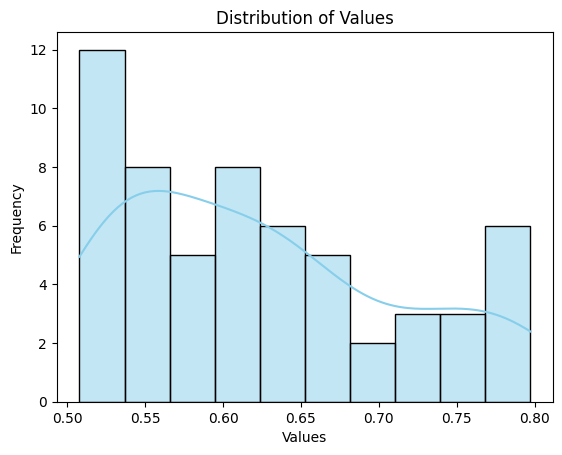

In [ ]:
sns.histplot(coefficients_df_var['r^2'], kde=True, color='skyblue', bins=10)  # Adjust bins as needed
plt.title('Distribution of Values')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

#test

In [ ]:
pip install einops

##dnabert

In [5]:
df = pd.read_csv(path_for_df_normalized_final).drop(['Unnamed: 0'], axis = 1)
#adding prob sequence full
df_gene_prob_sequence = pd.read_csv(our_gene_path)

df_gene_prob_sequence = df_gene_prob_sequence[['Name','AlleleA_ProbeSeq']]

#merging
df_final = pd.merge(df , df_gene_prob_sequence
                 , how='left'
                 , left_on='cg'
                 , right_on='Name')

df_final = df_final.drop(['Name'], axis = 1)
df_final


<ipython-input-5-23cd5883dddb>:3: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_gene_prob_sequence = pd.read_csv(our_gene_path)


,source_name,cg,value,age,our_gene,article,AlleleA_ProbeSeq
0,GSM2333902,cg00002028,0.022672,55.0,PINK1,PINK1,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAAC...
1,GSM2333903,cg00002028,0.020650,23.0,PINK1,PINK1,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAAC...
2,GSM2333901,cg00002028,0.025571,72.0,PINK1,PINK1,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAAC...
3,GSM2333905,cg00002028,0.035011,74.0,PINK1,PINK1,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAAC...
4,GSM2333908,cg00002028,0.031354,38.0,PINK1,PINK1,CCCAAATTTATTATAACCAACAAAAAACACCAATAATAACAACAAC...
...,...,...,...,...,...,...,...
3277736,GSM2334627,cg27664530,0.070926,53.0,PIK3AP1,PIK3AP1,CCTAAACTCCRTAAACCCACAAAAAACRCTCAAACAATCCTAAATA...
3277737,GSM2334630,cg27664530,0.124881,70.0,PIK3AP1,PIK3AP1,CCTAAACTCCRTAAACCCACAAAAAACRCTCAAACAATCCTAAATA...
3277738,GSM2334631,cg27664530,0.111110,72.0,PIK3AP1,PIK3AP1,CCTAAACTCCRTAAACCCACAAAAAACRCTCAAACAATCCTAAATA...
3277739,GSM2334632,cg27664530,0.118449,54.0,PIK3AP1,PIK3AP1,CCTAAACTCCRTAAACCCACAAAAAACRCTCAAACAATCCTAAATA...


In [ ]:
# Your actual data
my_dna_sequences = list(df_final['AlleleA_ProbeSeq']) # Replace with your list of DNA sequences
my_ages = list(df_final['age'])         # Replace with your list of ages
my_values = list(df_final['value'])      # Replace with your list of target values

# Rest of the script
import torch
from torch import nn, optim
from transformers import BertModel, AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset, random_split

class CustomDNABERTModel(nn.Module):
    def __init__(self):
        super(CustomDNABERTModel, self).__init__()
        self.dnabert = BertModel.from_pretrained("zhihan1996/DNABERT-2-117M")
        self.age_linear = nn.Linear(1, 50)  # Process age
        self.output_linear = nn.Sequential(
            nn.Linear(768 + 50, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, age):
        outputs = self.dnabert(input_ids)
        pooled_output = outputs[1]
        age_output = self.age_linear(age.unsqueeze(1))
        combined_output = torch.cat((pooled_output, age_output), dim=1)
        return self.output_linear(combined_output)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M")

# Tokenize DNA sequences
inputs = tokenizer(my_dna_sequences, padding=True, truncation=True, return_tensors="pt")
input_ids = inputs["input_ids"]
attention_masks = inputs["attention_mask"]
ages = torch.tensor(my_ages, dtype=torch.float32)
values = torch.tensor(my_values, dtype=torch.float32)


# Create a dataset and split into train and validation sets
dataset = TensorDataset(input_ids, attention_masks, ages, values)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Model, optimizer, and loss function
model = CustomDNABERTModel()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = nn.BCELoss()

# Training loop
num_epochs = 3  # Example epoch number
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        batch_input_ids, batch_attention_masks, batch_ages, batch_values = batch
        optimizer.zero_grad()
        predictions = model(batch_input_ids, batch_ages).squeeze()
        loss = loss_fn(predictions, batch_values)
        loss.backward()
        optimizer.step()

# Evaluation loop
model.eval()
total_loss = 0
with torch.no_grad():
    for batch in val_loader:
        batch_input_ids, batch_attention_masks, batch_ages, batch_values = batch
        predictions = model(batch_input_ids, batch_ages).squeeze()
        loss = loss_fn(predictions, batch_values)
        total_loss += loss.item()
avg_loss = total_loss / len(val_loader)
print(f"Average validation loss: {avg_loss}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/168k [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


config.json:   0%|          | 0.00/862 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/468M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.5.attention.self.query.weight', 'bert.encoder.layer.2.attention.self.value.weight', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.5.attention.self.key.bias', 'bert.encoder.layer.7.intermediate.dense.weight', 'bert.encoder.layer.8.attention.self.value.bias', 'bert.encoder.layer.8.attention.self.key.weight', 'bert.pooler.dense.weight', 'bert.encoder.layer.5.intermediate.dense.bias', 'bert.encoder.layer.11.attention.self.query.bias', 'bert.encoder.layer.4.output.LayerNorm.bias', 'bert.encoder.layer.7.output.dense.bias', 'bert.encoder.layer.4.output.dense.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.2.intermediate.dense.bias', 'bert.encoder.layer.6.output.LayerNorm.bias', 'bert.encoder.l

In [ ]:
dna_sequences = df_final['AlleleA_ProbeSeq']
dna_sequences = list(set(dna_sequences))
len(dna_sequences)

11716

In [ ]:
import torch
from transformers import AutoTokenizer, BertModel

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = BertModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

# Example list of DNA sequences
dna_sequences = dna_sequences

# Iterate over the DNA sequences and process each
for dna in dna_sequences:
    inputs = tokenizer(dna, return_tensors='pt')["input_ids"]
    with torch.no_grad():  # Disable gradient calculation for inference
        hidden_states = model(inputs)[0]  # [1, sequence_length, 768]



The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.10.intermediate.dense.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.1.output.dense.weight', 'bert.encoder.layer.6.output.dense.bias', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.3.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.11.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.self.key.weight', 'bert.encoder.layer.11.attention.self.query.bias', 'bert.encoder.layer.4.attention.self.value.bias', 'bert.encoder.layer.7.attention.self.key.bias', 'bert.embeddings.position_embeddings.weight', '

KeyboardInterrupt: ignored

In [ ]:
import torch
from transformers import AutoTokenizer, BertModel

tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = BertModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)

dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"
inputs = tokenizer(dna, return_tensors='pt')["input_ids"]
hidden_states = model(inputs)[0]  # [1, sequence_length, 768]

# embedding with mean pooling
embedding_mean = torch.mean(hidden_states[0], dim=0)
print(embedding_mean.shape)  # expect to be [768]

# embedding with max pooling
embedding_max = torch.max(hidden_states[0], dim=0)[0]
print(embedding_max.shape)  # expect to be [768]


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


pytorch_model.bin:   0%|          | 0.00/468M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.encoder.layer.10.output.dense.bias', 'bert.encoder.layer.10.intermediate.dense.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.1.output.dense.weight', 'bert.encoder.layer.6.output.dense.bias', 'bert.encoder.layer.4.attention.self.key.bias', 'bert.encoder.layer.3.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.11.attention.self.query.weight', 'bert.encoder.layer.11.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.self.key.weight', 'bert.encoder.layer.11.attention.self.query.bias', 'bert.encoder.layer.4.attention.self.value.bias', 'bert.encoder.layer.7.attention.self.key.bias', 'bert.embeddings.position_embeddings.weight', 'bert.encoder.layer.7.attention.self.key.weight', 'bert.encoder.layer.8.attention.self.query.bias', 'bert

torch.Size([768])
torch.Size([768])


In [ ]:
dfss = pd.read_csv(our_gene_path)
dfss

<ipython-input-4-fdc0596b43be>:1: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dfss = pd.read_csv(our_gene_path)


,IlmnID,Name,AddressA_ID,AlleleA_ProbeSeq,AddressB_ID,AlleleB_ProbeSeq,Infinium_Design_Type,Next_Base,Color_Channel,Forward_Sequence,...,UCSC_RefGene_Group,UCSC_CpG_Islands_Name,Relation_to_UCSC_CpG_Island,Phantom,DMR,Enhancer,HMM_Island,Regulatory_Feature_Name,Regulatory_Feature_Group,DHS
0,cg00035864,cg00035864,31729416,AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAA...,NaN,NaN,II,NaN,NaN,AATCCAAAGATGATGGAGGAGTGCCCGCTCATGATGTGAAGTACCT...,...,TSS1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cg00050873,cg00050873,32735311,ACAAAAAAACAACACACAACTATAATAATTTTTAAAATAAATAAAC...,31717405.0,ACGAAAAAACAACGCACAACTATAATAATTTTTAAAATAAATAAAC...,I,A,Red,TATCTCTGTCTGGCGAGGAGGCAACGCACAACTGTGGTGGTTTTTG...,...,Body;TSS1500,chrY:9363680-9363943,N_Shore,NaN,NaN,NaN,Y:9973136-9976273,NaN,NaN,NaN
2,cg00061679,cg00061679,28780415,AAAACATTAAAAAACTAATTCACTACTATTTAATTACTTTATTTTC...,NaN,NaN,II,NaN,NaN,TCAACAAATGAGAGACATTGAAGAACTAATTCACTACTATTTGGTT...,...,Body;Body;Body,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cg00063477,cg00063477,16712347,TATTCTTCCACACAAAATACTAAACRTATATTTACAAAAATACTTC...,NaN,NaN,II,NaN,NaN,CTCCTGTACTTGTTCATTAAATAATGATTCCTTGGATATACCAAGT...,...,Body,chrY:22737825-22738052,S_Shelf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cg00121626,cg00121626,19779393,AAAACTAATAAAAATAACTTACAAACCAAATACTATACCCTACAAC...,NaN,NaN,II,NaN,NaN,AGGTGAATGAAGAGACTAATGGGAGTGGCTTGCAAGCCAGGTACTG...,...,Body,chrY:21664481-21665063,N_Shore,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486423,65622344,NORM_T,Purple,Norm_T59,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486424,57640346,NORM_C,Green,Norm_C60,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486425,47715450,NORM_T,Purple,Norm_T60,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486426,28673402,NORM_C,Green,Norm_C61,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
stirng = dfss.iloc[0,3]
stirng

'AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAAATTC'

In [ ]:
from itertools import permutations


In [ ]:
# Define the size of the n-gram
n = 4
# Generate 4-grams using a sliding window
four_grams = [stirng[i:i+n] for i in range(len(stirng) - n + 1)]
four_grams

['AAAA',
 'AAAC',
 'AACA',
 'ACAC',
 'CACT',
 'ACTA',
 'CTAA',
 'TAAC',
 'AACA',
 'ACAA',
 'CAAT',
 'AATC',
 'ATCT',
 'TCTT',
 'CTTA',
 'TTAT',
 'TATC',
 'ATCC',
 'TCCA',
 'CCAC',
 'CACA',
 'ACAT',
 'CATA',
 'ATAA',
 'TAAA',
 'AAAC',
 'AACC',
 'ACCC',
 'CCCT',
 'CCTT',
 'CTTA',
 'TTAA',
 'TAAA',
 'AAAT',
 'AATT',
 'ATTT',
 'TTTA',
 'TTAT',
 'TATC',
 'ATCT',
 'TCTC',
 'CTCA',
 'TCAA',
 'CAAA',
 'AAAT',
 'AATT',
 'ATTC']

In [ ]:
import gym
import numpy as np

class DNAEnvironment(gym.Env):
    def __init__(self, dna_sequence):
        super(DNAEnvironment, self).__init__()
        self.dna_sequence = dna_sequence
        self.observation_space = gym.spaces.Discrete(len(dna_sequence))  # Each position in the sequence is a distinct state
        self.action_space = gym.spaces.Discrete(2)       # Match, No Match
        self.current_position = 0

    def reset(self):
        self.current_position = 0
        return self.current_position

    def step(self, action):
        reward = 0

        if action == 0:  # Match
            if self.dna_sequence[self.current_position] == 'A':
                reward = 1
            else:
                reward = -1

        self.current_position += 1

        done = self.current_position == len(self.dna_sequence) - 1

        return self.current_position, reward, done, {}

# Example usage
your_dna_sequence = "AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAAATTC"

env = DNAEnvironment(your_dna_sequence)

# Q-learning algorithm (you may need to fine-tune hyperparameters)
Q = np.zeros((env.observation_space.n, env.action_space.n))

alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration-exploitation tradeoff

for episode in range(1000):
    state = env.reset()

    while True:
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Exploration
        else:
            action = np.argmax(Q[state, :])  # Exploitation

        next_state, reward, done, _ = env.step(action)

        Q[state, action] = Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])

        state = next_state

        if done:
            break

# Print the learned Q values
print("Learned Q values:")
print(Q)


Learned Q values:
[[ 6.12943999  4.97927944]
 [ 5.69937777  4.6619359 ]
 [ 5.22153086  4.19582417]
 [ 4.69058984  3.64797467]
 [ 3.02141611  4.10065538]
 [ 4.55628375  3.51770277]
 [ 2.753065    3.95142639]
 [ 3.3643194   4.39047377]
 [ 4.87830419  3.84612177]
 [ 4.30922688  3.22242821]
 [ 2.65859619  3.67691875]
 [ 4.08546528  3.05676629]
 [ 3.42829475  2.3637857 ]
 [ 1.67130642  2.69810528]
 [ 1.98472472  2.99789476]
 [ 2.30925706  3.33099418]
 [ 2.66873568  3.70110464]
 [ 4.11233849  3.03055901]
 [ 2.43929108  3.45815388]
 [ 2.77732354  3.84239319]
 [ 3.2308724   4.26932577]
 [ 4.7436953   3.72150128]
 [ 3.08729432  4.15966145]
 [ 4.62184605  3.57760637]
 [ 2.99571292  4.02427339]
 [ 4.47141488  3.4541593 ]
 [ 3.85712764  2.84986336]
 [ 3.17458627  2.15751344]
 [ 1.41005013  2.41620697]
 [ 1.67498071  2.68467441]
 [ 1.97762296  2.98297156]
 [ 2.29608194  3.31441285]
 [ 2.65205853  3.68268094]
 [ 4.09186772  3.03968433]
 [ 3.43540857  2.41381582]
 [ 2.70600953  1.68944654]
 [ 0.87875

https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


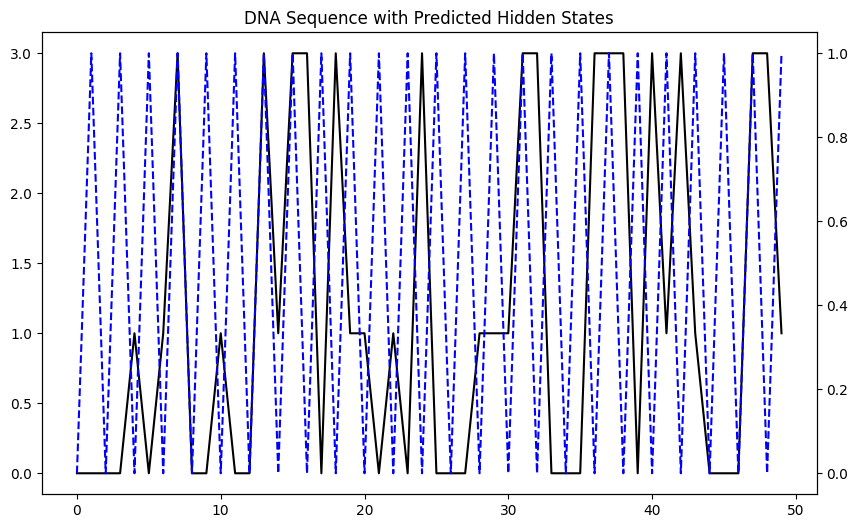

In [ ]:
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt

# Replace 'your_dna_sequence' with your actual DNA sequence
your_dna_sequence = "AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAAATTC"

# Convert DNA sequence to numerical representation
symbol_mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
numerical_sequence = np.array([symbol_mapping[s] for s in your_dna_sequence])

# Create an HMM model
model = hmm.MultinomialHMM(n_components=2, n_iter=100)

# Reshape the sequence for fitting the model
obs = numerical_sequence.reshape(-1, 1)

# Fit the model to the observations
model.fit(obs)

# Predict the hidden states
hidden_states = model.predict(obs)

# Plot the DNA sequence with predicted hidden states
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the DNA sequence
ax1.plot(range(len(your_dna_sequence)), numerical_sequence, label='DNA Sequence', color='black')

# Create a second y-axis for the hidden states
ax2 = ax1.twinx()
ax2.plot(range(len(your_dna_sequence)), hidden_states, label='Hidden States', color='blue', linestyle='dashed')

# Show the plot
plt.title("DNA Sequence with Predicted Hidden States")
plt.show()


In [ ]:
from hmmlearn import hmm
import numpy as np

# Replace 'your_dna_sequence' with your actual DNA sequence
your_dna_sequence = "AAAACACTAACAATCTTATCCACATAAACCCTTAAATTTATCTCAAATTC"

# Convert DNA sequence to numerical representation
# You might want to customize this based on your problem
# For example, you can use A=0, C=1, G=2, T=3
symbol_mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
numerical_sequence = np.array([symbol_mapping[s] for s in your_dna_sequence])

# Create an HMM model
model = hmm.MultinomialHMM(n_components=2, n_iter=100)

# Reshape the sequence for fitting the model
obs = numerical_sequence.reshape(-1, 1)

# Fit the model to the observations
model.fit(obs)

# Predict the hidden states
hidden_states = model.predict(obs)

# Print the predicted hidden states
print("Predicted Hidden States:")
print(hidden_states)


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Predicted Hidden States:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# Define the range of n-grams (2 to 25)
ngram_range = range(2, 7)

# Initialize a set to store unique n-grams
unique_ngrams = set()

# Generate unique permutations for each n-gram size
for n in ngram_range:
    ngrams = [''.join(p) for p in permutations(stirng, 4)]
    unique_ngrams.update(ngrams)
len(unique_ngrams)


81

In [ ]:
unique_ngrams

{'AAAA',
 'AAAC',
 'AAAT',
 'AACA',
 'AACC',
 'AACT',
 'AATA',
 'AATC',
 'AATT',
 'ACAA',
 'ACAC',
 'ACAT',
 'ACCA',
 'ACCC',
 'ACCT',
 'ACTA',
 'ACTC',
 'ACTT',
 'ATAA',
 'ATAC',
 'ATAT',
 'ATCA',
 'ATCC',
 'ATCT',
 'ATTA',
 'ATTC',
 'ATTT',
 'CAAA',
 'CAAC',
 'CAAT',
 'CACA',
 'CACC',
 'CACT',
 'CATA',
 'CATC',
 'CATT',
 'CCAA',
 'CCAC',
 'CCAT',
 'CCCA',
 'CCCC',
 'CCCT',
 'CCTA',
 'CCTC',
 'CCTT',
 'CTAA',
 'CTAC',
 'CTAT',
 'CTCA',
 'CTCC',
 'CTCT',
 'CTTA',
 'CTTC',
 'CTTT',
 'TAAA',
 'TAAC',
 'TAAT',
 'TACA',
 'TACC',
 'TACT',
 'TATA',
 'TATC',
 'TATT',
 'TCAA',
 'TCAC',
 'TCAT',
 'TCCA',
 'TCCC',
 'TCCT',
 'TCTA',
 'TCTC',
 'TCTT',
 'TTAA',
 'TTAC',
 'TTAT',
 'TTCA',
 'TTCC',
 'TTCT',
 'TTTA',
 'TTTC',
 'TTTT'}

In [ ]:
%%time
df_new = []
df_new_article = []
data = {'article': [], 'our_source': []}
df_article_vs_our_source = pd.DataFrame(data)
elias = elias.fillna("None")
acadaemic = acadaemic.fillna("None")

for elem_idx in range(len(elias)):
    for elem2_idx in range(len(acadaemic)):
      our = [value for value in elias.iloc[elem_idx, :] if "None" not in str(value)]
      article = [value for value in acadaemic.iloc[elem2_idx, :] if "None" not in str(value)]
      if any(word1 in our for word1 in article):
          # add to two different columns at the same dataframe
          df_article_vs_our_source = df_article_vs_our_source.append({'our_source': elias.iloc[elem_idx, 0], 'article': acadaemic.iloc[elem2_idx, 0]}, ignore_index=True)

df_article_vs_our_source = df_article_vs_our_source.drop_duplicates().reset_index(drop =True)
display(df_article_vs_our_source)



In [ ]:
df_normalized_final = pd.read_csv(path_for_df_normalized_final)
df_normalized_final = df_normalized_final.drop(['Unnamed: 0'], axis= 1)
df_normalized_final = df_normalized_final.groupby(['age','cg'])['value'].var().reset_index().sort_values(by=['cg', 'age'])

    #grouped by cg and age
grouped = df_normalized_final.groupby(['cg','age']).var().reset_index()

display(df_normalized_final)

,age,cg,value
0,20.0,cg00002028,0.000011
11716,21.0,cg00002028,0.000028
23432,22.0,cg00002028,0.000063
35148,23.0,cg00002028,0.000023
46864,24.0,cg00002028,0.000004
...,...,...,...
667811,76.0,cg27664530,0.001405
679527,77.0,cg27664530,0.000189
691243,78.0,cg27664530,0.000270
702959,79.0,cg27664530,0.000246


In [ ]:
df = data_preparation.get_normalized_data_after_cleaning()[['source_name','cg','value','age','article']]
df

<ipython-input-5-f78d2f60bf48>:45: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_our_gene_data_orginal = pd.read_csv('{}'.format(self.our_path_gene_source))


,source_name,cg,value,age,article
0,GSM2333902,cg00002028,0.022672,55.0,PINK1
1,GSM2333903,cg00002028,0.020650,23.0,PINK1
2,GSM2333901,cg00002028,0.025571,72.0,PINK1
3,GSM2333905,cg00002028,0.035011,74.0,PINK1
4,GSM2333908,cg00002028,0.031354,38.0,PINK1
...,...,...,...,...,...
3277736,GSM2334627,cg27664530,0.070926,53.0,PIK3AP1
3277737,GSM2334630,cg27664530,0.124881,70.0,PIK3AP1
3277738,GSM2334631,cg27664530,0.111110,72.0,PIK3AP1
3277739,GSM2334632,cg27664530,0.118449,54.0,PIK3AP1


In [ ]:
cat_columns=['source_name','cg','article']
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0] + 2)
df

,source_name,cg,value,age,article
0,2,2,0.022672,55.0,2
1,3,2,0.020650,23.0,2
2,4,2,0.025571,72.0,2
3,5,2,0.035011,74.0,2
4,6,2,0.031354,38.0,2
...,...,...,...,...,...
3277736,274,11717,0.070926,53.0,448
3277737,275,11717,0.124881,70.0,448
3277738,276,11717,0.111110,72.0,448
3277739,277,11717,0.118449,54.0,448


In [ ]:
Y = (df['value']).values
x = df.drop(['value'], axis = 1)
x = (x).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2949966, 4) (2949966,)
(327775, 4) (327775,)


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout , MaxPool2D
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.layers import Dense,Dropout, Flatten , Conv2D, MaxPooling2D , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

model = models.Sequential()
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout((0.5)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout((0.5)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='softmax'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
%%time
epochs = 20
batch_size = 64
history = model.fit(X_train, Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1
                    ,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])




Epoch 1/20
41484/41484 [==============================] - 110s 3ms/step - loss: 0.4677 - accuracy: 3.0923e-04 - val_loss: 0.4677 - val_accuracy: 3.1865e-04
Epoch 2/20
41484/41484 [==============================] - 107s 3ms/step - loss: 0.4677 - accuracy: 3.0923e-04 - val_loss: 0.4677 - val_accuracy: 3.1865e-04
Epoch 3/20
41484/41484 [==============================] - 108s 3ms/step - loss: 0.4677 - accuracy: 3.0923e-04 - val_loss: 0.4677 - val_accuracy: 3.1865e-04
Epoch 4/20
41484/41484 [==============================] - 113s 3ms/step - loss: 0.4677 - accuracy: 3.0923e-04 - val_loss: 0.4677 - val_accuracy: 3.1865e-04
CPU times: user 11min 49s, sys: 1min 29s, total: 13min 18s
Wall time: 7min 17s


In [ ]:
ann = data_preparation.ann()
ann

<ipython-input-11-0ad93f8abc32>:45: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_our_gene_data_orginal = pd.read_csv('{}'.format(self.our_path_gene_source))


Epoch 1/20
41484/41484 [==============================] - 113s 3ms/step - loss: 0.4677 - accuracy: 3.0923e-04 - val_loss: 0.4677 - val_accuracy: 3.1865e-04
Epoch 2/20
41484/41484 [==============================] - 111s 3ms/step - loss: 0.4677 - accuracy: 3.0923e-04 - val_loss: 0.4677 - val_accuracy: 3.1865e-04
Epoch 3/20
41484/41484 [==============================] - 111s 3ms/step - loss: 0.4677 - accuracy: 3.0923e-04 - val_loss: 0.4677 - val_accuracy: 3.1865e-04
Epoch 4/20
41484/41484 [==============================] - 109s 3ms/step - loss: 0.4677 - accuracy: 3.0923e-04 - val_loss: 0.4677 - val_accuracy: 3.1865e-04
